In [8]:
from pathlib import Path
import pandas as pd

In [9]:
def strip_non_numeric(s):
    return ''.join(c for c in s if c.isdigit() or c in ['.', '-'])

def parse(line):


    metric_dict = {}
    # Split the line
    metrics = line.split(',')

    for metric in metrics:

        try:
            if 'tpr' in metric:
                metric_dict['tpr'] = float(strip_non_numeric(metric.rsplit()[-1]))
            if 'tnr' in metric:
                metric_dict['tnr'] = float(strip_non_numeric(metric.rsplit()[-1]))
            if 'loss' in metric:
                metric_dict['loss'] = float(strip_non_numeric(metric.rsplit()[-1]))
        except Exception as e:
            print(e)
            print('Error parsing metric: ', metric)
            raise e

    return metric_dict

def process_logfile(log_file_path: Path):

    # Read the log file
    with open(log_file_path, 'r') as file:
        lines = file.readlines()

    training_metrics = {}
    validation_metrics = {}


    trn = 0
    val = 0
    while lines:

        # Get the first line
        line = lines.pop(0)

        # Check if the line contains the training metrics
        if 'Training' in line:
            training_metrics[trn] = parse(','.join([lines.pop(0) for _ in range(3)]))
            trn+=1

        # Check if the line contains the validation metrics
        if 'Validation' in line:
            validation_metrics[val] = parse(','.join([lines.pop(0) for _ in range(2)]))
            val+=1


    return pd.DataFrame.from_dict(training_metrics, orient='index'), pd.DataFrame.from_dict(validation_metrics, orient='index')

log_file_paths = [log_file_path for log_file_path in Path('trained_summit/partial').rglob('log')]

subset_logs = {
    f'partial' : {'training': {},'validation': {}}
}

for fdx, log_file_path in enumerate(log_file_paths):
    print(log_file_path)

    fold = log_file_path.parts[-2]

    trn, val = process_logfile(log_file_path)
    subset_logs[fold]['training'] = trn
    subset_logs[fold]['validation'] = val

trained_summit/partial/log


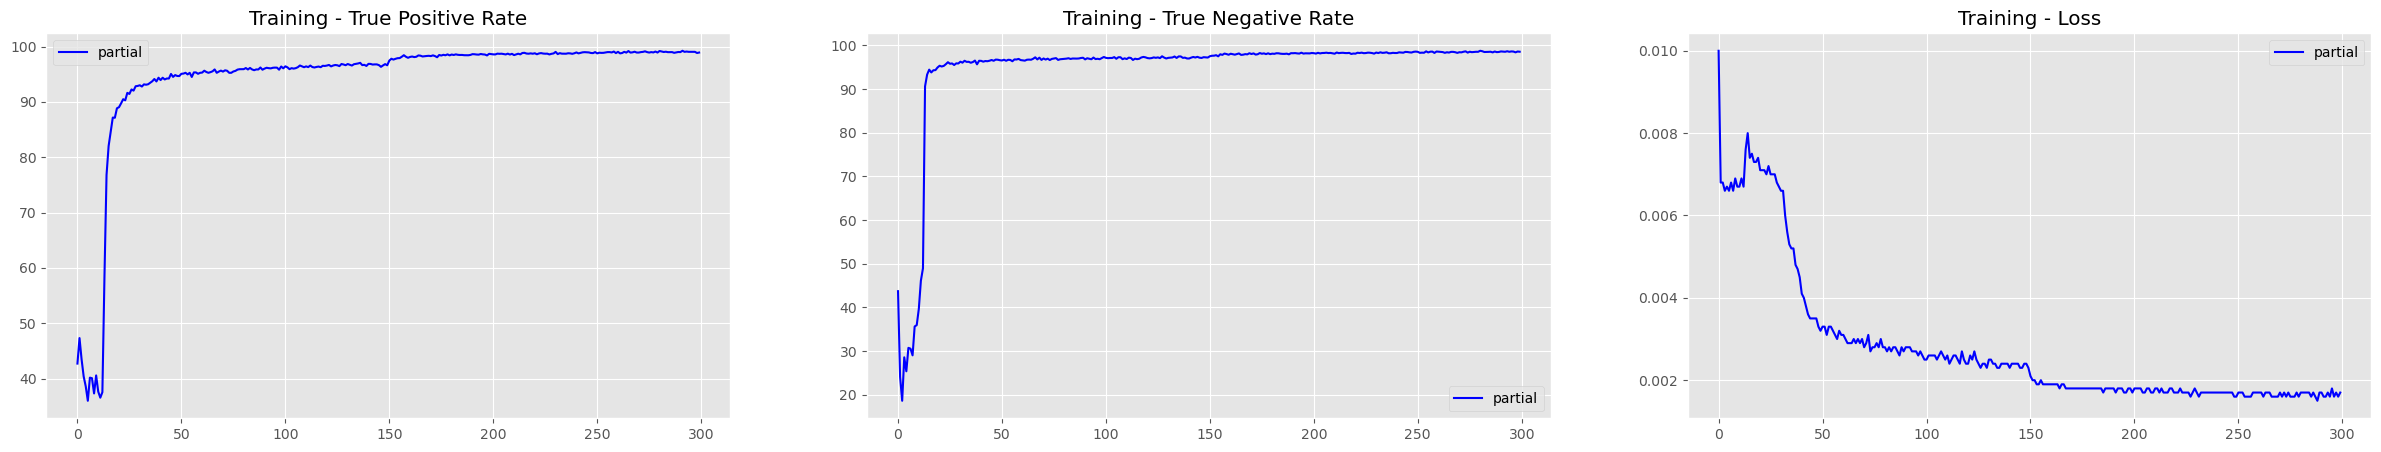

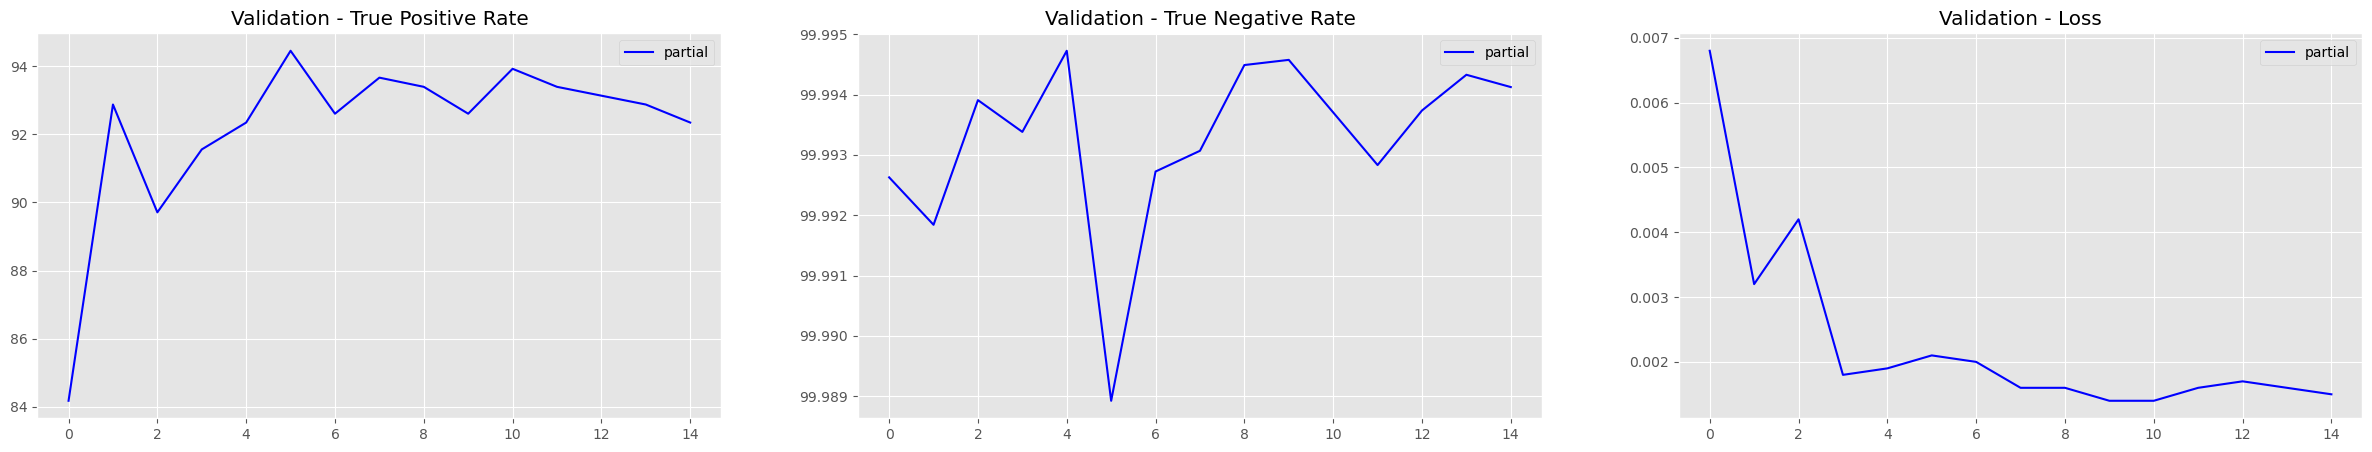

In [10]:
from os import linesep
import matplotlib.pyplot as plt

def plot_training_data(metrics, dataset):

    

    title_maps = {
        'loss': 'Loss',
        'tpr': 'True Positive Rate',
        'tnr': 'True Negative Rate'
    }

    fig, ax = plt.subplots(1, 3, figsize=(30, 5))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']
    linestyles = ['-', '--', '-.', ':', '-.', '--', '-', ':', '-.', '--']
    

    for fdx, fold in enumerate(metrics):
        data = metrics[fold][dataset]

        for idx, metric in enumerate(data.columns):
            ax[idx].plot(data[metric], label=f'{fold}', color=colors[fdx], linestyle=linestyles[fdx])
            ax[idx].set_title(f'{dataset.capitalize()} - {title_maps[metric]}')
            ax[idx].legend()

    plt.style.use('ggplot')
    plt.show()


plot_training_data(subset_logs, 'training')
plot_training_data(subset_logs, 'validation')